In [1]:
import pandas as pd
import seaborn as sns

In [2]:
orginal_df = pd.read_csv("/mnt/data/public/bgg/bgg-19m-reviews.csv")

In [5]:
orginal_df = orginal_df.iloc[:,1:]

# EDA

In [19]:
duplicates = orginal_df[orginal_df.duplicated(subset=["user", "name"], keep=False)]

In [20]:
duplicates.sort_values(by="user")

,user,rating,comment,ID,name


In [11]:
sample = pd.read_csv("/mnt/data/public/bgg/games_detailed_info.csv")

/tmp/ipykernel_341/317015783.py:1: DtypeWarning: Columns (29,48) have mixed types. Specify dtype option on import or set low_memory=False.
  sample = pd.read_csv("/mnt/data/public/bgg/games_detailed_info.csv")


In [17]:
print(sample[sample["id"] == 129622])
print(sample[sample["id"] == 277085])

    Unnamed: 0       type      id  \
17          17  boardgame  129622   

                                            thumbnail  \
17  https://cf.geekdo-images.com/T1ltXwapFUtghS9A7...   

                                                image      primary  \
17  https://cf.geekdo-images.com/T1ltXwapFUtghS9A7...  Love Letter   

                                            alternate  \
17  ['Letters to Santa', 'List Miłosny', 'Lista Sk...   

                                          description  yearpublished  \
17  All of the eligible young men (and many of the...           2012   

    minplayers  ...  War Game Rank Customizable Rank Children's Game Rank  \
17           2  ...            NaN               NaN                  NaN   

   RPG Item Rank  Accessory Rank  Video Game Rank  Amiga Rank  \
17           NaN             NaN              NaN         NaN   

    Commodore 64 Rank Arcade Rank Atari ST Rank  
17                NaN         NaN           NaN  

[1 rows x 56 columns]


they just save the common names under names, but same name have different editions (example, the two rows below are the regular vs premium edition)

based on my opinion, i suggest to sort by item ID since premium editions may come at different price points/qualities

In [22]:
duplicates = orginal_df[orginal_df.duplicated(subset=["user", "ID"], keep=False)]

In [23]:
duplicates.sort_values(by="user")

,user,rating,comment,ID,name


if we sort by ID though, no duplicates

# Make Utility Matrix

In [25]:
orginal_df = orginal_df[["user","rating","ID"]]
orginal_df = orginal_df.rename(columns={"user": "user_name", 
                        "ID": "item_id"})

In [26]:
print(orginal_df["user_name"].nunique(), "unique users")
print(orginal_df["item_id"].nunique(), "unique games")


412815 unique users
21839 unique games


In [27]:
def calculate_sparsity(orginal_df):
    n_users = orginal_df['user_name'].nunique()
    n_items = orginal_df['item_id'].nunique()
    n_ratings = len(orginal_df)
    sparsity = 1 - (n_ratings / (n_users * n_items))
    return sparsity, n_users, n_items, n_ratings

# Test different thresholds
thresholds = [(50, 3), (100, 5), (150, 10), (200, 15)]

for min_items, min_users in thresholds:
    orginal_df_temp = orginal_df.copy()
    
    # Filter items
    item_mask = orginal_df_temp['item_id'].value_counts() >= min_items
    valid_items = orginal_df_temp['item_id'].value_counts()[item_mask].index
    orginal_df_temp = orginal_df_temp[orginal_df_temp['item_id'].isin(valid_items)]
    
    # Filter users
    user_mask = orginal_df_temp['user_name'].value_counts() >= min_users
    valid_users = orginal_df_temp['user_name'].value_counts()[user_mask].index
    orginal_df_temp = orginal_df_temp[orginal_df_temp['user_name'].isin(valid_users)]
    
    sparsity, n_u, n_i, n_r = calculate_sparsity(orginal_df_temp)
    print(f"Min items: {min_items}, Min users: {min_users}")
    print(f"  Users: {n_u}, Items: {n_i}, Ratings: {n_r}")
    print(f"  Sparsity: {sparsity:.4f} ({(1-sparsity)*100:.3f}% filled)\n")

Min items: 50, Min users: 3
  Users: 304062, Items: 17325, Ratings: 18658095
  Sparsity: 0.9965 (0.354% filled)

Min items: 100, Min users: 5
  Users: 270213, Items: 12133, Ratings: 18184180
  Sparsity: 0.9945 (0.555% filled)

Min items: 150, Min users: 10
  Users: 221662, Items: 9744, Ratings: 17571412
  Sparsity: 0.9919 (0.814% filled)

Min items: 200, Min users: 15
  Users: 188839, Items: 8254, Ratings: 16937850
  Sparsity: 0.9891 (1.087% filled)



In [28]:
item_counts = orginal_df['item_id'].value_counts()

<Axes: xlabel='count', ylabel='Count'>

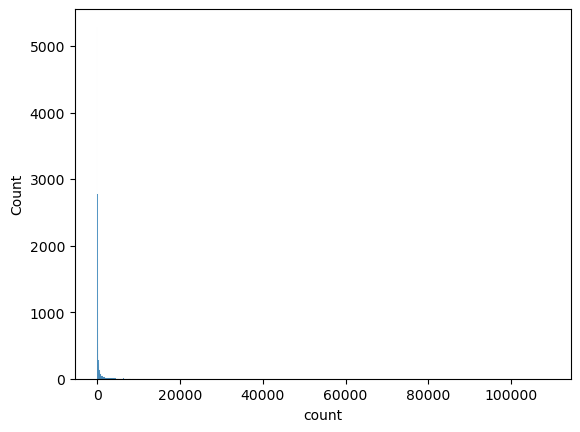

In [29]:
sns.histplot(item_counts)

In [30]:
user_counts = orginal_df["user_name"].value_counts()

<Axes: xlabel='count', ylabel='Count'>

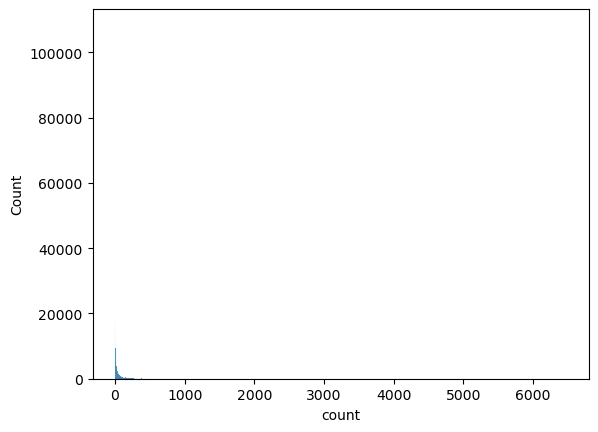

In [31]:
sns.histplot(user_counts)

In [32]:
# Keep only games with at least 500 reviews
min_item_reviews = 500 
item_mask = orginal_df['item_id'].value_counts() >= min_item_reviews
item_over_min = orginal_df['item_id'].value_counts()[item_mask].index
df = orginal_df[orginal_df['item_id'].isin(item_over_min)]

# Optionally, filter users with at least 5 ratings
min_user_reviews = 5
user_mask = orginal_df['user_name'].value_counts() >= min_user_reviews
user_over_min = orginal_df['user_name'].value_counts()[user_mask].index
df = df[df['user_name'].isin(user_over_min)]


In [ ]:
df_utility = df.pivot_table(index = "user_name",
                            columns = "item_id",
                            values = "rating")

/tmp/ipykernel_341/3469227913.py:1: PerformanceWarning: The following operation may generate 3304204156 cells in the resulting pandas object.
  df_utility = df.pivot_table(index = "user_name",
